In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import os

In [2]:
FIGSIZE = (12, 14)
CATEGORICAL_RESULTS_TO_SHOW = 10

In [3]:
def preprocess_for_visulization(data, x_col, y_col):
    # Drop rows with NaN values in the x_col and y_col columns
    data = data[[x_col, y_col]].dropna()

    # Convert 'veracity' column to numeric
    data[y_col] = pd.to_numeric(data[y_col])

    return data

In [4]:
def plot_boxplot_figure(data, x_col, y_col, title, save_path):
    plt.figure(figsize=FIGSIZE)
    sns.boxplot(data=data, x=y_col, y=x_col)
    plt.title(title)
    plt.xlabel(y_col)
    plt.ylabel(x_col)
    plt.savefig(save_path)
    plt.close()

In [5]:
def print_boxplot_statistics(data, x_col, y_col, title):
    boxplot_stats = data.groupby(y_col)[x_col].describe()
    print(f"Boxplot statistics for {title}:\n")
    print(boxplot_stats)

In [6]:
def convert_column_to_numeric(data, column):
    data[column] = pd.to_numeric(data[column], errors='coerce')
    return data

In [7]:
def drop_na_rows(data, columns):
    data_no_na = data[columns].dropna()
    return data_no_na

In [8]:
def calculate_pearsonr_correlation(data, x_col, y_col):
    pearsonr, p_value = scipy.stats.pearsonr(data[y_col], data[x_col])
    return pearsonr, p_value

In [9]:
def interpret_relationship(corr, p_value, x_col, y_col):
    if corr > 0:
        relationship = "positive"
    elif corr < 0:
        relationship = "negative"
    else:
        relationship = "no"

    if abs(corr) >= 0.7:
        strength = "strong"
    elif abs(corr) >= 0.3:
        strength = "moderate"
    else:
        strength = "weak"

    print(f"The correlation of {corr} indicates {relationship} relationship between {x_col} and {y_col} is {strength}.")

    if p_value < 0.05:
        print("The P-value is less than 0.05, which suggests that there is a statistically significant relationship between the two variables.")
    else:
        print("The P-value is greater than 0.05, which suggests that there is no statistically significant relationship between the two variables.")

In [10]:
def print_correlation(data, x_col, y_col):
    corr, p_value = calculate_pearsonr_correlation(data, x_col, y_col)
    interpret_relationship(corr, p_value, x_col, y_col)

In [11]:
def create_true_rumour_summary_table(data, x_col, y_col):
    true_rumour_counts = data.groupby(x_col)[y_col].sum()
    total_counts = data[x_col].value_counts()
    proportion_true_rumours = (true_rumour_counts / total_counts)
    filtered_proportions = proportion_true_rumours[(proportion_true_rumours > 0) & (total_counts >= CATEGORICAL_RESULTS_TO_SHOW)]
    sorted_proportions = filtered_proportions.sort_values(ascending=False)
    percentage_true_rumours = (filtered_proportions * 100).round(2)
    summary = pd.concat([total_counts, percentage_true_rumours], axis=1)
    summary = summary.loc[sorted_proportions.index]
    summary.columns = ['Count', 'Percentage of true rumours']
    summary = summary.sort_values('Percentage of true rumours', ascending=False)
    print(f"Relationship summary between {x_col} and {y_col}:\n{summary}")

    return summary, sorted_proportions

In [12]:
def plot_bar_chart(sorted_proportions, title, save_path):
    plt.figure(figsize=FIGSIZE)
    ax1 = plt.gca()
    sorted_proportions.plot(kind='bar', ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Percentage of true rumours')
    ax1.set_xticklabels([shorten_label(label.get_text()) for label in ax1.get_xticklabels()])
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=12)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
    plt.savefig(save_path)
    plt.close()

In [13]:
def create_matplotlib_table(summary, save_path):
    _, ax = plt.subplots(figsize=FIGSIZE)
    ax.axis('off')
    table = ax.table(cellText=summary.values, rowLabels=[shorten_label(label) for label in summary.index], colLabels=summary.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.auto_set_column_width(col=list(range(len(summary.columns))))
    table.scale(1, 1.5)

    plt.savefig(save_path) 
    plt.close()

In [14]:
def calculate_class_proportions(y):
    class_counts = y.value_counts()
    total_count = len(y)
    class_proportions = class_counts / total_count
    return class_proportions

In [15]:
def plot_class_distribution(y, title='Class Distribution', save_path=None):
    class_proportions = calculate_class_proportions(y)
    plt.figure(figsize=FIGSIZE)
    plt.bar(class_proportions.index, class_proportions.values)
    plt.xlabel('Class')
    plt.ylabel('Proportion')
    plt.xticks([0, 1])
    plt.title(title)

    if save_path:
        plt.savefig(save_path)

In [16]:
def shorten_label(label):
    if len(label) > 15:
        return label[:15] + '...'
    return label

In [17]:
def plot_confusion_matrix(model_name, y_test, y_pred, save_path):
    print("\nPlotting confusion matrix...")
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(save_path)
    plt.close()

In [18]:
def plot_feature_importances(model_name, model, X_train, save_path):
    model_importances = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1], reverse=True)
    importances_df = pd.DataFrame(model_importances, columns=['Feature', 'Importance'])
    plt.figure(figsize=FIGSIZE)
    sns.barplot(x='Importance', y='Feature', data=importances_df.head(10))
    plt.title(f"{model_name} Feature Importances")
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig(save_path)
    plt.close()

In [19]:
def show_continuous_relationship(data, continuous_features, y_col):
    for feature in continuous_features:
        if feature in data.columns:
            data_continuous = preprocess_for_visulization(data, feature, y_col)
            save_path = os.path.join('results', f"{feature}_vs_{y_col}_boxplot.png")
            plot_boxplot_figure(data_continuous, feature, y_col, f"{feature} vs. {y_col}", save_path)
            print_boxplot_statistics(data_continuous, feature, y_col, f"{feature} vs. {y_col}")
        else:
            print(f"Feature not found in the data: {feature}")
        data = convert_column_to_numeric(data, y_col)
        data_no_na = drop_na_rows(data, [feature, y_col])
        print_correlation(data_no_na, feature, y_col)

In [20]:
def show_categorical_relationship(data, categorical_features, y_col):
    for feature in categorical_features:
        if feature in data.columns:
            data_categorical = data[[feature, y_col]].dropna()
            summary, sorted_proportions = create_true_rumour_summary_table(data_categorical, feature, y_col)

            # Check if the DataFrame is not empty
            if not sorted_proportions.empty:
                save_path_bar_chart = os.path.join('results', f"{feature}_vs_{y_col}_bar_chart.png")
                plot_bar_chart(sorted_proportions, f"{feature} vs. {y_col}", save_path_bar_chart)

                save_path_summary_table = os.path.join('results', f"{feature}_vs_{y_col}_summary_table.png")
                create_matplotlib_table(summary, save_path_summary_table)
            else:
                print(f"Warning: The DataFrame for {feature} and {y_col} is empty. Skipping the plot.")
        else:
            print(f"Feature not found in the data: {feature}")

In [21]:
def visualize_and_analyze(data, continuous_features, categorical_features, y_col):
    # Create 'results' directory if it doesn't exist
    if not os.path.exists('results'):
        os.makedirs('results')

    target_col_data = data[y_col]
    
    plot_class_distribution(target_col_data, title='Class Distribution in Training Set', save_path=os.path.join('results', 'class_distribution_train.png'))

    show_continuous_relationship(data, continuous_features, y_col)

    show_categorical_relationship(data, categorical_features, y_col)

In [22]:
def main():
    data = utils.pandas_load_csv("output_data.csv")

    #Plot the relationship between the specified features and veracity
    continuous_features_to_analyze = ['age', 'time_to_transfer_window', 'market_value']
    categorical_features_to_analyze = ['nationality', 'position', 'source']
    visualize_and_analyze(data, continuous_features_to_analyze, categorical_features_to_analyze, 'veracity')

Boxplot statistics for age vs. veracity:

           count       mean       std   min   25%   50%   75%   max
veracity                                                           
0         1938.0  26.196594  4.106362  17.0  23.0  26.0  29.0  37.0
1          542.0  25.350554  4.477381  18.0  22.0  24.0  28.0  36.0
The correlation of -0.0831863667829644 indicates negative relationship between age and veracity is weak.
The P-value is less than 0.05, which suggests that there is a statistically significant relationship between the two variables.
Boxplot statistics for time_to_transfer_window vs. veracity:

           count       mean        std  min   25%   50%   75%    max
veracity                                                            
0         1401.0  62.381156  44.593373  0.0  25.0  55.0  92.0  157.0
1          431.0  52.832947  42.006422  0.0  19.0  43.0  74.0  157.0
The correlation of -0.09170915728953069 indicates negative relationship between time_to_transfer_window and veracit

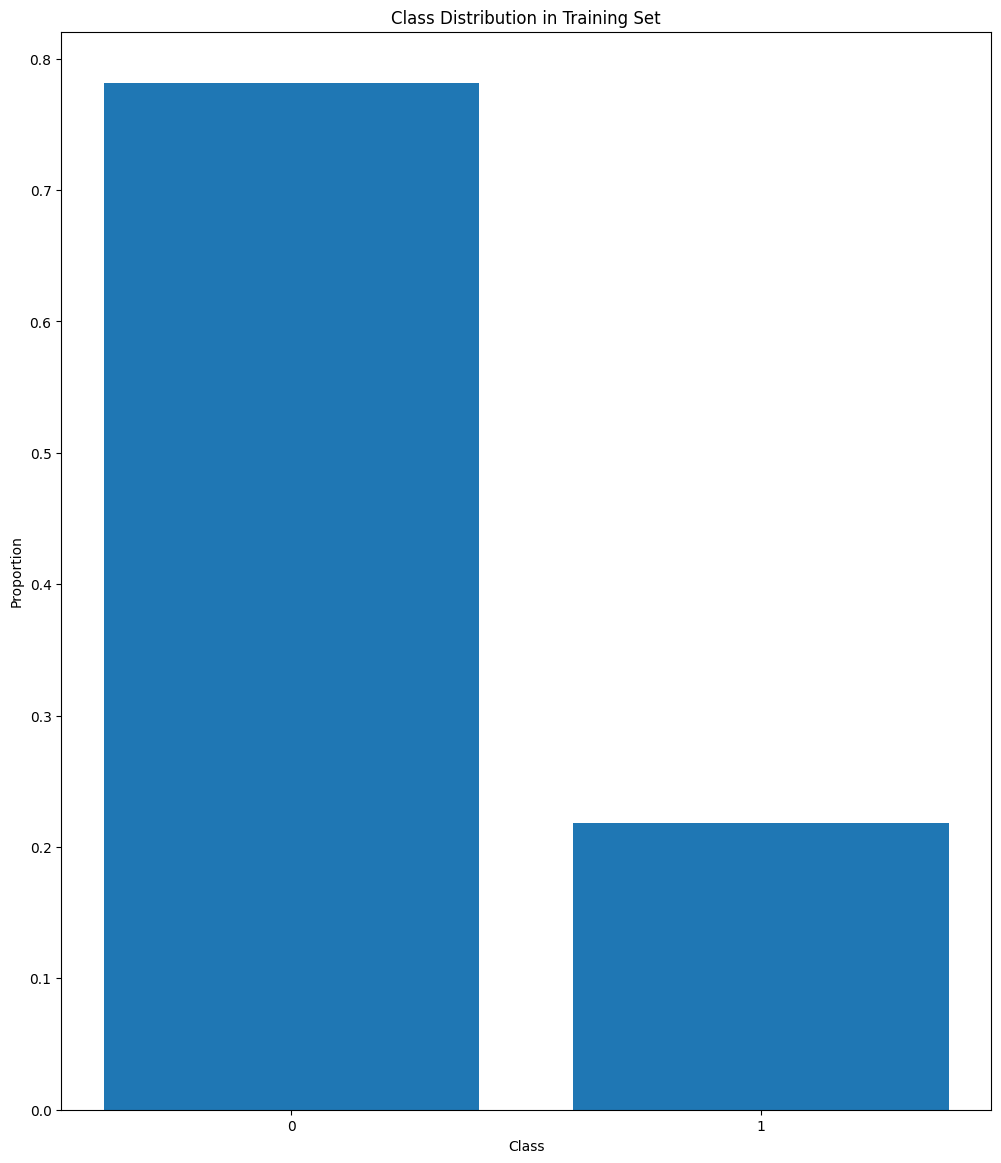

In [23]:
if __name__ == '__main__':
    main()